# TODO
1. Be able to run this through without any problems
    - Account for not wanting to run this analysis again
1. Handle entries with time < 0

# Call Center Exploratory Data Analysis I
The main purpose of this notebook is to begin exploring the service request dataset, and note any directions that may be worth pursuing once we have a good idea of it's structure.

## Overview
- Load cleaned call center data that was previously generated
- Add a `neighborhood` column that shows which neighborhood the request is in
- Look at the geospatial distribution of these events
    - Where are most happening?
    - Which areas have the most closed/open requests?
    - Which areas have receive attention the fastest?

In [1]:
# Standard tools for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Tools specific for geospatial data analysis
from mpl_toolkits.basemap import Basemap
import shapely
from shapely.geometry import shape, mapping, Point, Polygon
import geopandas as gpd
import geojsonio
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

# Tools from the Python Standard Library
import os
import re

from IPython.display import display
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Data preparation

In [2]:
RESULTSDIR = '../results/'
!ls $RESULTSDIR

01-air_quality.h5      01-neighborhoods.h5    02-service_requests.h5
01-crime.h5            01-service_requests.h5


Read in the DataFrame that was previously generated. If a file containing the results of this notebook already exists, read that. Otherwise, run all the processing analyses again.

In [3]:
service_requests = pd.read_hdf(RESULTSDIR + '01-service_requests.h5')

In [4]:
service_requests.head()

REQUESTID        DATETIMEINIT          SOURCE  \
0      21090 2009-07-01 10:24:19  Phone or Email   
1      21091 2009-07-01 11:14:09  Phone or Email   
2      21092 2009-07-01 15:58:47  Phone or Email   
3      21093 2009-07-01 15:59:26  Phone or Email   
4      21094 2009-07-01 16:03:05  Phone or Email   

                                  DESCRIPTION REQCATEGORY  STATUS  \
0          Yard Trimmings - Food Pail Request   RECYCLING  CLOSED   
1            City Services - Missed Recycling   RECYCLING  CLOSED   
2  Yard Trimmings Service Issue (Residential)   RECYCLING  CLOSED   
3               Yard Trimmings - Cart Request   RECYCLING  CLOSED   
4   Residential Recycling - Oil - Kit Request   RECYCLING  CLOSED   

       DATETIMECLOSED               coordinates  time_to_close  \
0 2009-07-27 11:34:09  (37.807708, -122.248339)           26.0   
1 2009-07-03 11:10:08  (37.809762, -122.259388)            1.0   
2 2009-07-27 11:33:58  (37.755521, -122.175515)           25.0   
3 2009-07-03 11:09:54  (37.868229, -122.243706)            1.0   
4 2009-07-03 14:30:07  (37.835057, -122.212352)            1.0   

     time_since_init  
0 3084 days 13:35:41  
1 3084 days 12:45:51  
2 3084 days 08:01:13  
3 3084 days 08:00:34  
4 3084 days 07:56:55

In [5]:
service_requests.shape

(402305, 10)

Read in the neighborhood information:

In [6]:
DATADIR = '../data/'

In [7]:
neighborhoods = gpd.read_file(DATADIR + 'neighborhoods/oakland_neighborhoods_clean.shp')

In [8]:
neighborhoods.head()

name  center_lon  center_lat  \
0         Acorn/ Acorn Industrial -122.308714   37.802146   
1                     Adams Point -122.254662   37.812118   
2                       Allendale -122.203566   37.787141   
3                    Arroyo Viejo -122.178464   37.760061   
4  Bancroft Business/ Havenscourt -122.184941   37.766929   

                                            geometry  
0  POLYGON ((-122.280212520786 37.8025938890711, ...  
1  POLYGON ((-122.247844000895 37.810057515347, -...  
2  POLYGON ((-122.196320300415 37.7863349418319, ...  
3  POLYGON ((-122.170503431087 37.759584556553, -...  
4  POLYGON ((-122.177112657994 37.7654884250132, ...

Now that we have only the shapes of these regions, we can determine which neighborhoods these requests are occuring in.

The code below uses an RTree to spatially index neighborhoods and points to determine which neighborhood a point belongs to.

In [9]:
# Come up with a GeoDataFrame containing points from the service requests
req_nodes = gpd.GeoDataFrame(data={'coords': service_requests['coordinates']})
req_nodes.name = 'nodes'
req_nodes['geometry'] = req_nodes.apply(lambda row: Point((row['coords'][1], row['coords'][0])), axis=1)

# Create a spatial index
sindex = req_nodes.sindex

In [10]:
# Loop through each neighborhood
for idx, neighborhood in neighborhoods.iterrows():
    possible_matches_index = list(sindex.intersection(neighborhood['geometry'].bounds))
    possible_matches = req_nodes.iloc[possible_matches_index]
    
    # Catch errors that occur when there's a "side location conflict..."
    try:
        precise_matches = possible_matches[possible_matches.intersects(neighborhood['geometry'])]
    except:
        print("INVALID COORDINATE")
        
    service_requests.loc[precise_matches.index, 'neighborhood'] = neighborhood['name']

TopologyException: side location conflict at -122.1393346786749 37.737391181756728


INVALID


In [11]:
service_requests.head(10)

REQUESTID        DATETIMEINIT          SOURCE  \
0       21090 2009-07-01 10:24:19  Phone or Email   
1       21091 2009-07-01 11:14:09  Phone or Email   
2       21092 2009-07-01 15:58:47  Phone or Email   
3       21093 2009-07-01 15:59:26  Phone or Email   
4       21094 2009-07-01 16:03:05  Phone or Email   
7       21097 2009-07-02 13:23:31  Phone or Email   
8       21103 2009-07-06 16:03:05  Phone or Email   
9       21104 2009-07-06 16:06:23  Phone or Email   
10      21098 2009-07-02 14:34:58  Phone or Email   
11      21099 2009-07-02 16:37:52  Phone or Email   

                                   DESCRIPTION REQCATEGORY  STATUS  \
0           Yard Trimmings - Food Pail Request   RECYCLING  CLOSED   
1             City Services - Missed Recycling   RECYCLING  CLOSED   
2   Yard Trimmings Service Issue (Residential)   RECYCLING  CLOSED   
3                Yard Trimmings - Cart Request   RECYCLING  CLOSED   
4    Residential Recycling - Oil - Kit Request   RECYCLING  CLOSED   
7               Yard Trimmings - Missed Pickup   RECYCLING  CLOSED   
8               Yard Trimmings - Missed Pickup   RECYCLING  CLOSED   
9               Yard Trimmings - Missed Pickup   RECYCLING  CLOSED   
10                   Business - Green Business   RECYCLING  CLOSED   
11       Residential Recycling - Missed Pickup   RECYCLING  CLOSED   

        DATETIMECLOSED               coordinates  time_to_close  \
0  2009-07-27 11:34:09  (37.807708, -122.248339)           26.0   
1  2009-07-03 11:10:08  (37.809762, -122.259388)            1.0   
2  2009-07-27 11:33:58  (37.755521, -122.175515)           25.0   
3  2009-07-03 11:09:54  (37.868229, -122.243706)            1.0   
4  2009-07-03 14:30:07  (37.835057, -122.212352)            1.0   
7  2009-07-20 10:37:51  (37.756948, -122.157659)           17.0   
8  2009-07-27 11:32:35  (37.729191, -122.178221)           20.0   
9  2009-07-27 11:32:05  (37.728911, -122.178293)           20.0   
10 2009-07-02 14:35:16  (37.829876, -122.247805)            0.0   
11 2009-07-03 14:29:56   (33.15263, -117.170977)            0.0   

      time_since_init       neighborhood  
0  3084 days 13:35:41  Cleveland Heights  
1  3084 days 12:45:51           Lakewide  
2  3084 days 08:01:13            Webster  
3  3084 days 08:00:34     Panoramic Hill  
4  3084 days 07:56:55          Merriwood  
7  3083 days 10:36:29      Toler Heights  
8  3079 days 07:56:55      Sobrante Park  
9  3079 days 07:53:37      Sobrante Park  
10 3083 days 09:25:02    Piedmont Avenue  
11 3083 days 07:22:08                NaN

Here, we can see that we are missing some values with neighborhoods.

In [12]:
service_requests.head()

REQUESTID        DATETIMEINIT          SOURCE  \
0      21090 2009-07-01 10:24:19  Phone or Email   
1      21091 2009-07-01 11:14:09  Phone or Email   
2      21092 2009-07-01 15:58:47  Phone or Email   
3      21093 2009-07-01 15:59:26  Phone or Email   
4      21094 2009-07-01 16:03:05  Phone or Email   

                                  DESCRIPTION REQCATEGORY  STATUS  \
0          Yard Trimmings - Food Pail Request   RECYCLING  CLOSED   
1            City Services - Missed Recycling   RECYCLING  CLOSED   
2  Yard Trimmings Service Issue (Residential)   RECYCLING  CLOSED   
3               Yard Trimmings - Cart Request   RECYCLING  CLOSED   
4   Residential Recycling - Oil - Kit Request   RECYCLING  CLOSED   

       DATETIMECLOSED               coordinates  time_to_close  \
0 2009-07-27 11:34:09  (37.807708, -122.248339)           26.0   
1 2009-07-03 11:10:08  (37.809762, -122.259388)            1.0   
2 2009-07-27 11:33:58  (37.755521, -122.175515)           25.0   
3 2009-07-03 11:09:54  (37.868229, -122.243706)            1.0   
4 2009-07-03 14:30:07  (37.835057, -122.212352)            1.0   

     time_since_init       neighborhood  
0 3084 days 13:35:41  Cleveland Heights  
1 3084 days 12:45:51           Lakewide  
2 3084 days 08:01:13            Webster  
3 3084 days 08:00:34     Panoramic Hill  
4 3084 days 07:56:55          Merriwood

Let's group by neighborhood and get some descriptive statistics:

In [13]:
service_requests['neighborhood'].value_counts()[:10]

Clawson           9478
Prescott          8056
Hoover/ Foster    7186
Longfellow        6723
Downtown          6628
McClymonds        5624
Adams Point       5547
Temescal          5139
Highland          4723
Clinton           4684
Name: neighborhood, dtype: int64

## 2. Response times of requests

### a. Time required to close requests

Let's look at the distribution of times to close requests, in units of days.

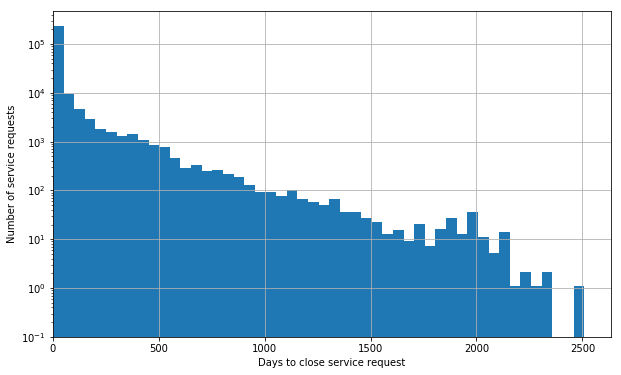

In [14]:
(service_requests[(service_requests['STATUS'] == 'CLOSED') & (service_requests['time_to_close'] > 0)]['time_to_close']
                 .hist(bins=50, bottom=0.1))
plt.xlim(xmin=0)
plt.yscale('log')
plt.ylabel('Number of service requests');
plt.xlabel('Days to close service request');
plt.savefig('../fig/02-call_center_time_close.png')

The above figure gives us a rough idea of how these are distributed, but there are a few nuances to take into account:
1. This includes any reports that were instantly opened and closed, adding more counts at the lower end.
1. Operators may close irrelevant requests after some arbitrary length of time.
1. Processing time for closing requests may make this interval seem longer.

In order to account for these, greater care must be taken of the nature of the requests being made. Nonetheless, it appears that there is an exponential drop for wait times.

What is the average time for waiting?

In [15]:
service_requests['time_to_close'].mean()

31.894477832495504

The time to close has a mean of a month, but we can see that there are still quite a few that take longer. How about we look at these values over the different neighborhoods?

Let's look at the top 10 neighborhoods in their wait time:

In [16]:
(service_requests.groupby('neighborhood')[['time_to_close']]
                 .mean()
                 .sort_values('time_to_close', ascending=False)
)[:10]

time_to_close
neighborhood                     
Montclair Business     106.455592
Lakeshore               95.181675
Rockridge               92.723456
Crocker Highland        82.300366
Sheffield Village       72.253886
Panoramic Hill          68.520661
Upper Rockridge         65.078017
Trestle Glen            63.718921
Downtown                62.699500
Piedmont Avenue         62.503664

And now the bottom 10 (i.e., with the fastest response):

In [17]:
(service_requests.groupby('neighborhood')[['time_to_close']]
                 .mean()
                 .sort_values('time_to_close', ascending=True)
)[:10]

time_to_close
neighborhood                   
South Stonehurst       8.574407
McClymonds            11.052239
Clawson               13.699909
Melrose               13.873191
Highland              13.975417
Fremont               14.374847
Oak Tree              14.809773
Hoover/ Foster        14.855920
South Prescott        15.258308
Seminary              15.340615

Let's get a map of these to get a sense of how these are geospatially distributed. To do this, let's overlay the neighborhoods on top of a map, and color code the neighborhoods based on their mean time to close.

In [18]:
neighborhoods = neighborhoods.join(service_requests.groupby('neighborhood')['time_to_close'].mean(), on='name')

In [19]:
neighborhoods.head()

name  center_lon  center_lat  \
0         Acorn/ Acorn Industrial -122.308714   37.802146   
1                     Adams Point -122.254662   37.812118   
2                       Allendale -122.203566   37.787141   
3                    Arroyo Viejo -122.178464   37.760061   
4  Bancroft Business/ Havenscourt -122.184941   37.766929   

                                            geometry  time_to_close  
0  POLYGON ((-122.280212520786 37.8025938890711, ...      32.996510  
1  POLYGON ((-122.247844000895 37.810057515347, -...      31.483377  
2  POLYGON ((-122.196320300415 37.7863349418319, ...      23.263017  
3  POLYGON ((-122.170503431087 37.759584556553, -...      19.057064  
4  POLYGON ((-122.177112657994 37.7654884250132, ...      21.087178

https://ocefpaf.github.io/python4oceanographers/blog/2015/08/24/choropleth/

Longitude range:  (-122.35304219896193, -122.10048551341704)
Latitude range:  (37.68944924029288, 37.894234908415413)


/Users/kjbilton/Installs/miniconda2/envs/oakland/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


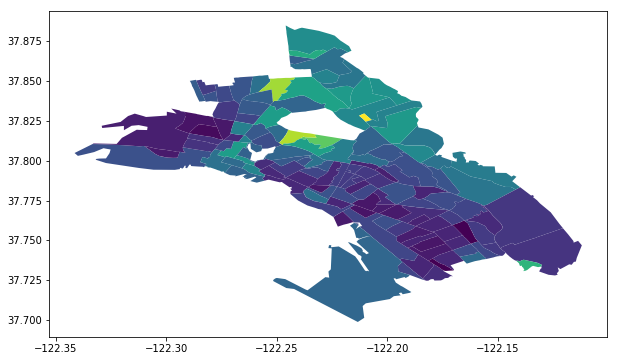

In [20]:
f, ax = plt.subplots()
neighborhoods.plot(column='time_to_close', ax=ax)

print('Longitude range: ', ax.get_xlim())
print('Latitude range: ', ax.get_ylim())

# Get the limits of our map
llcrnrlon, urcrnrlon = ax.get_xlim()
llcrnrlat, urcrnrlat = ax.get_ylim()

It will be useful to have a single function that can do this plotting for us:

In [21]:
coords = {'llcrnrlon' : llcrnrlon,
          'urcrnrlon' : urcrnrlon, 
          'llcrnrlat' : llcrnrlat,
          'urcrnrlat' : urcrnrlat}

In [22]:
def neighborhood_heat_map(data, col, coords=None, label=None, ax=None, xpixels=2000):
    """
    Plot a heat map on the neighborhoods listed in the data.
    
    Parameters
    ----------
    data : GeoDataFrame
        GeoDataFrame containing neighborhoods and their associated geometries.
    col : str
        String referring to a column name in data.
    coords : dict, default=None
        Dict with keys llcrnrlon, llcrnrlat, urcrnrlon, and urcrnrlat. If set to None, use max/min from 'Longitude'
        and 'Latitude' columns to determine the region.
    ax : matplotlib axis, default=None
        Plot the heat map to an axis ax. If set to None, a new figure and axis is created
    xpixels : int
        Resolution of the base map. Increasing this number increases the amount of detail contained in the base map.
        
    Returns
    -------
    Heat map of col overlayed on a satellite image.
    
    """
    
    # Create a canvas if an axis isn't provided
    if ax is None:
        fig = plt.figure(figsize=(10,10))
        axis = fig.add_axes([0.,0.,1.,1.])
    else:
        fig = ax.get_figure()
        axis = ax
        
    if coords is None:
        llcrnrlon = data['Longitude'].min()
        llcrnrlat = data['Latitude'].min()
        urcrnrlon = data['Longitude'].max()
        urcrnrlat = data['Latitude'].max()   
    else:
        llcrnrlon=coords['llcrnrlon']
        llcrnrlat=coords['llcrnrlat']
        urcrnrlon=coords['urcrnrlon']
        urcrnrlat=coords['urcrnrlat']

    # Create a map to overlay data on
    bm = Basemap(epsg=3493,
                 llcrnrlon=llcrnrlon,
                 llcrnrlat=llcrnrlat,
                 urcrnrlon=urcrnrlon,
                 urcrnrlat=urcrnrlat,
                 ax=axis)

    bm.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=xpixels)

    # Plot the neighborhood polygons
    patches = []

    for poly in data['geometry']:
        mpoly = shapely.ops.transform(bm, poly)
        patches.append(PolygonPatch(mpoly))

    pc = PatchCollection(patches, match_original=True)

    # Color code these patches based on the time_to_close of that neighborhood
    pc.set_array(data[col].values)
    pc.set_clim([data[col].min(), data[col].max()])


    axis.add_collection(pc)

    # Create a color bar
    cax = fig.add_axes([1.05, 0.1, 0.03, 0.8])
    cbar = fig.colorbar(pc, cax=cax)    
    
    if label is None:
        label = col

    cbar.set_label(label, rotation=270, labelpad=40, fontsize=20)
    
    if ax is None:
        return fig, axis

This is a nice little function to have around and use in any remaining notebooks. As a result, I have saved it in a separate file called `scripts/oakplot.py`.

/Users/kjbilton/Installs/miniconda2/envs/oakland/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


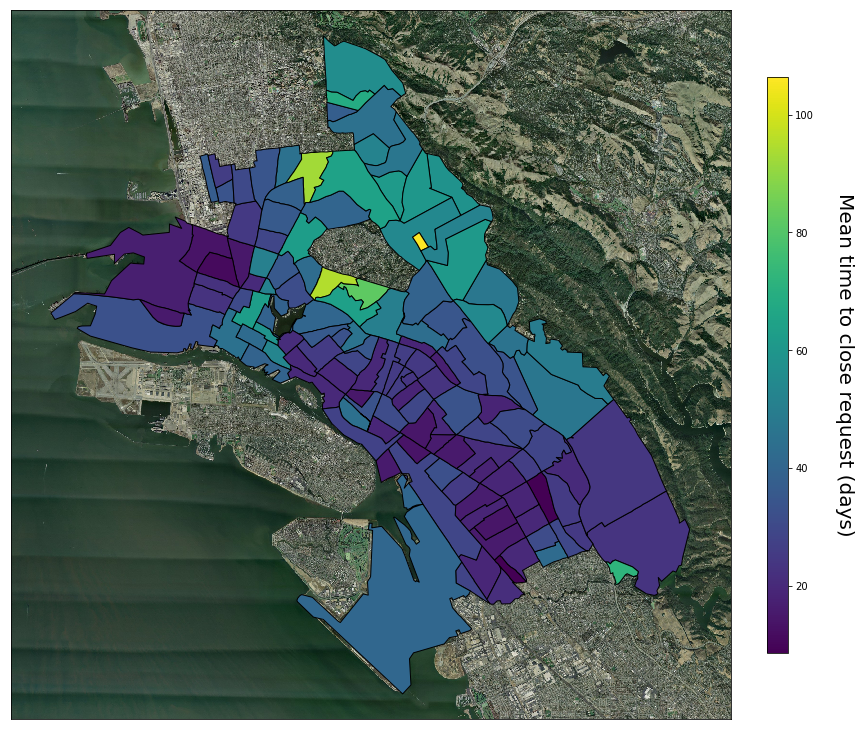

In [23]:
neighborhood_heat_map(data=neighborhoods,
                      col='time_to_close',
                      coords=coords,
                      label='Mean time to close request (days)',
                      ax=None,
                      xpixels=2000);

## b. Time between opening request and now* for open requests
- The above analysis only looks at closed requests, meaning we would be missing any that have been open for a long time. Let's look at how these lingering issues are distributed

In [24]:
service_requests.loc[:, 'time_since_init'] = service_requests['time_since_init'].astype('timedelta64[D]')

In [25]:
(service_requests[service_requests['STATUS'] == 'OPEN'].groupby('neighborhood')['time_since_init']
                                                       .mean()
                                                       .sort_values(ascending=False))[:10]

neighborhood
Not Named4           1072.000000
Panoramic Hill       1007.380952
Elmhurst Park        1003.184000
Shafter               989.746667
Woodminster           980.135135
Lincoln Highlands     959.030488
Crestmont             954.302326
Sequoyah              937.940909
Caballo Hills         937.698113
Sheffield Village     923.527778
Name: time_since_init, dtype: float64

In [26]:
(service_requests[service_requests['STATUS'] == 'OPEN'].groupby('neighborhood')['time_since_init']
                                                       .mean()
                                                       .sort_values(ascending=True))[:10]

neighborhood
Fairfax Business/  Wentworth/ Holland    414.714286
Civic Center                             448.493976
Melrose                                  457.615385
Peralta/ Laney                           471.071429
Not Named2                               508.714286
Downtown                                 508.762019
Lockwood Tevis                           523.553571
Hegenberger                              541.283784
Coliseum Industrial                      546.963415
Chinatown                                563.740331
Name: time_since_init, dtype: float64

In [27]:
mean_time_since_init = service_requests[service_requests['STATUS'] == 'OPEN'].groupby('neighborhood')['time_since_init'].mean()

In [28]:
neighborhoods = neighborhoods.join(mean_time_since_init, on='name')

/Users/kjbilton/Installs/miniconda2/envs/oakland/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


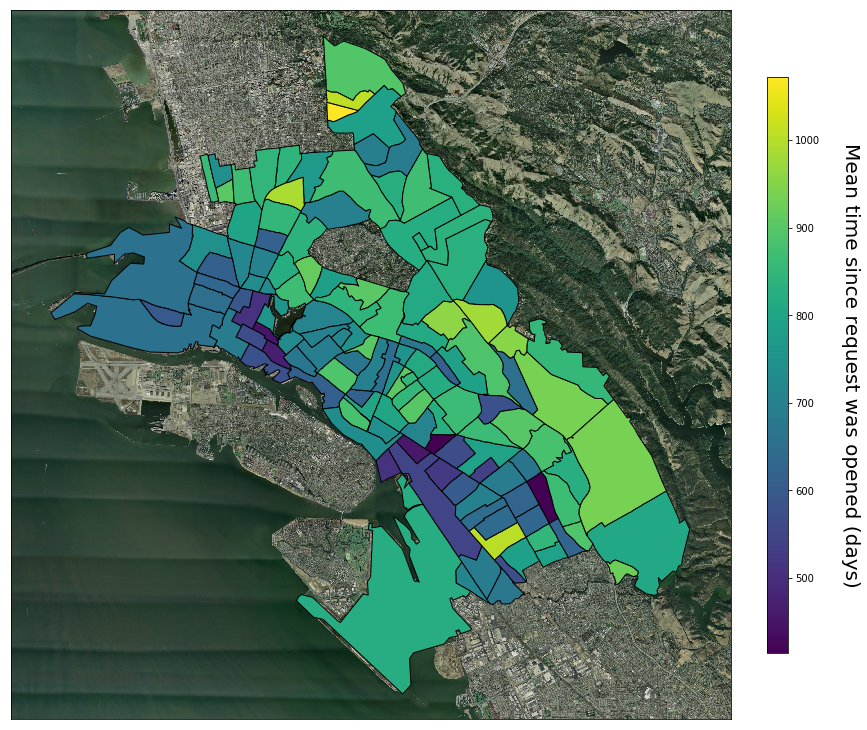

In [29]:
neighborhood_heat_map(data=neighborhoods,
                      col='time_since_init',
                      coords=coords,
                      label='Mean time since request was opened (days)',
                      ax=None,
                      xpixels=2000);

## 3. Specific categories of requests
So far, we have been agnostic to the details of the data. The above analyses regarding response times may be more interesting depending on the type of data we are looking at. Now we will consider the nature of the service request.

In [30]:
service_requests['REQCATEGORY'].unique()

array(['RECYCLING', 'ELECTRICAL', 'ROW', 'STREETSW', 'KOCB', 'ILLDUMP',
       'OTHER', 'TRAFFIC', 'TREES', 'WATERSHED', 'SEWERS', 'DRAINAGE',
       'TRAFFIC_ENGIN', 'METER_REPAIR', 'GRAFFITI', 'BLDGMAINT',
       'FACILITIES', 'PARKS', 'FIRE', nan, 'CUT_CLEAN', 'VEGCONTR',
       'CW_DIT_GIS', 'SURVEY', 'LAB', 'OPD'], dtype=object)

In [31]:
def counts_in_neighborhood(data, category):
    """ Returns the number of occurences for a specific category type in a DataFrame.
    
    Parameters
    ----------
    data : DataFrame
        DataFrame containing service requests.
    category : str
        String corresponding to service request category in DataFrame.
    """
    n_category = data[data['REQCATEGORY'] == category].groupby('neighborhood')['REQUESTID'].count()
    n_category.rename(f'N_{category}', inplace=True)
    
    return n_category

## Grafitti

In [32]:
n_graffiti = counts_in_neighborhood(service_requests, 'GRAFFITI')

In [33]:
neighborhoods = neighborhoods.join(n_graffiti, on='name')

/Users/kjbilton/Installs/miniconda2/envs/oakland/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


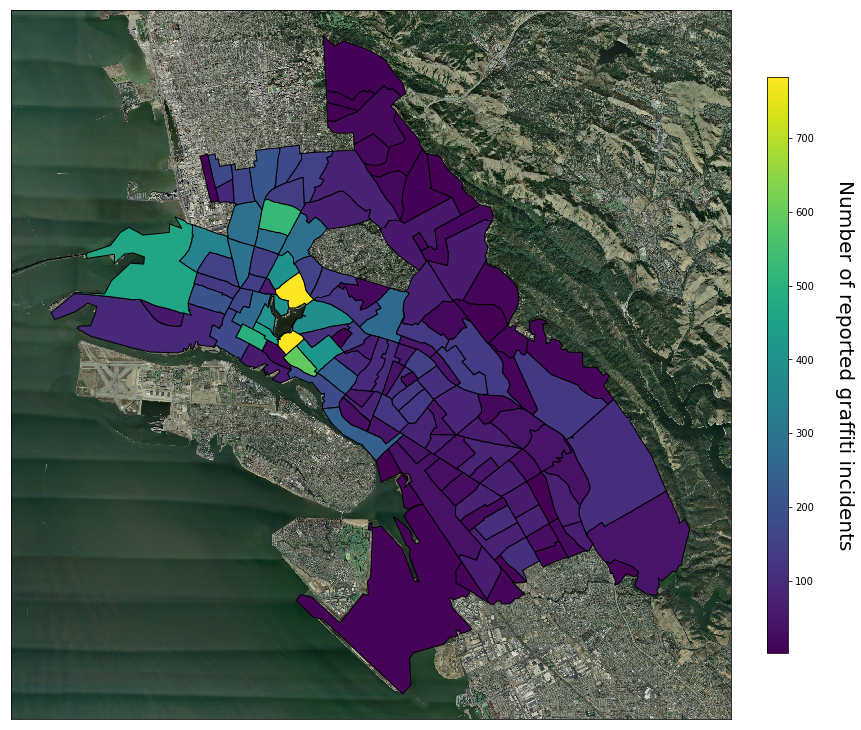

In [34]:
neighborhood_heat_map(data=neighborhoods,
                      col='N_GRAFFITI',
                      coords=coords,
                      label='Number of reported graffiti incidents',
                      ax=None,
                      xpixels=2000);

## Illegal dumping

In [35]:
n_dump = counts_in_neighborhood(service_requests, 'ILLDUMP')
neighborhoods = neighborhoods.join(n_dump, on='name')

/Users/kjbilton/Installs/miniconda2/envs/oakland/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


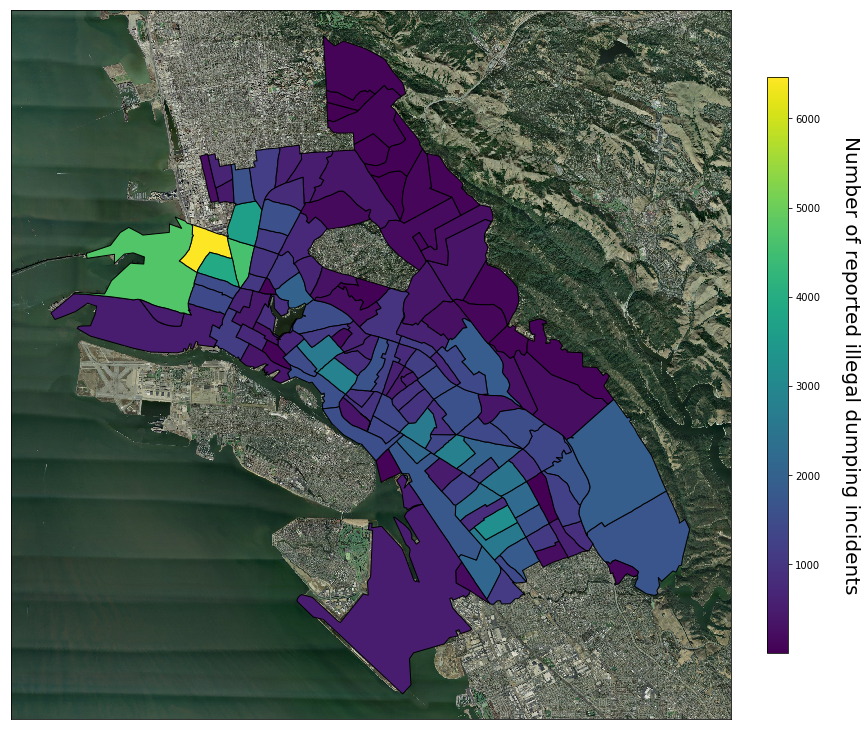

In [36]:
neighborhood_heat_map(data=neighborhoods,
                      col='N_ILLDUMP',
                      coords=coords,
                      label='Number of reported illegal dumping incidents',
                      ax=None,
                      xpixels=2000);

### Abandonded cars

In [37]:
n_abandoned_autos = (service_requests[service_requests['DESCRIPTION'] == 'Oakland Police - Abandoned Auto']
                        .groupby('neighborhood')['REQUESTID']
                        .count())

In [38]:
n_abandoned_autos.rename('N_AUTOS', inplace=True);

In [39]:
neighborhoods = neighborhoods.join(n_abandoned_autos, on='name')

/Users/kjbilton/Installs/miniconda2/envs/oakland/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


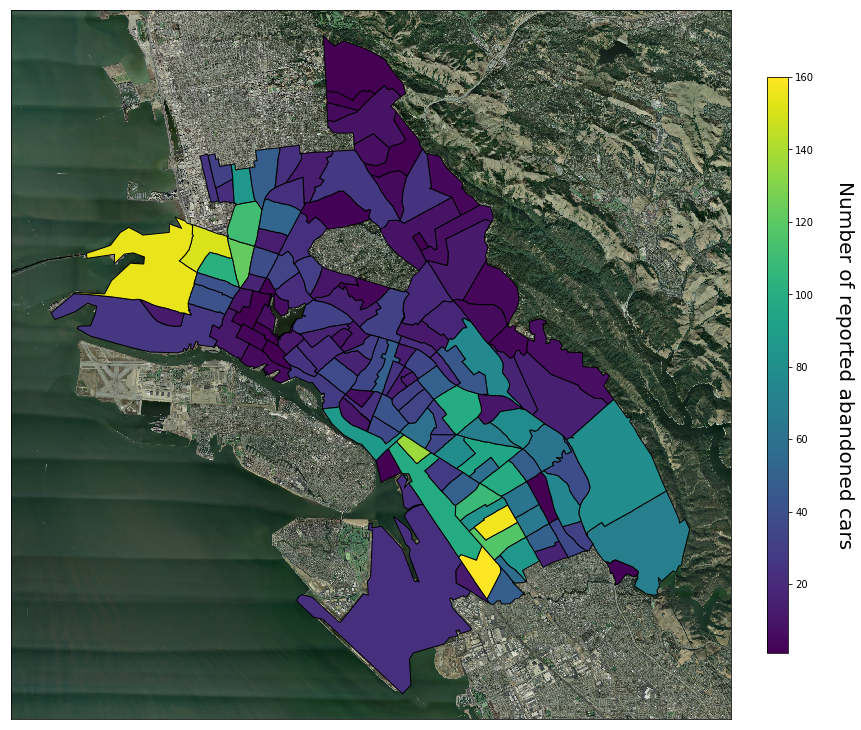

In [40]:
neighborhood_heat_map(data=neighborhoods,
                      col='N_AUTOS',
                      coords=coords,
                      label='Number of reported abandoned cars',
                      ax=None,
                      xpixels=2000);

### Homeless encampments

In [41]:
n_homeless = (service_requests[service_requests['DESCRIPTION'] == 'Homeless Encampment']
            .groupby('neighborhood')['REQUESTID']
            .count())

In [42]:
n_homeless.rename('N_HOMELESS', inplace=True);

In [43]:
neighborhoods = neighborhoods.join(n_homeless, on='name')

/Users/kjbilton/Installs/miniconda2/envs/oakland/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


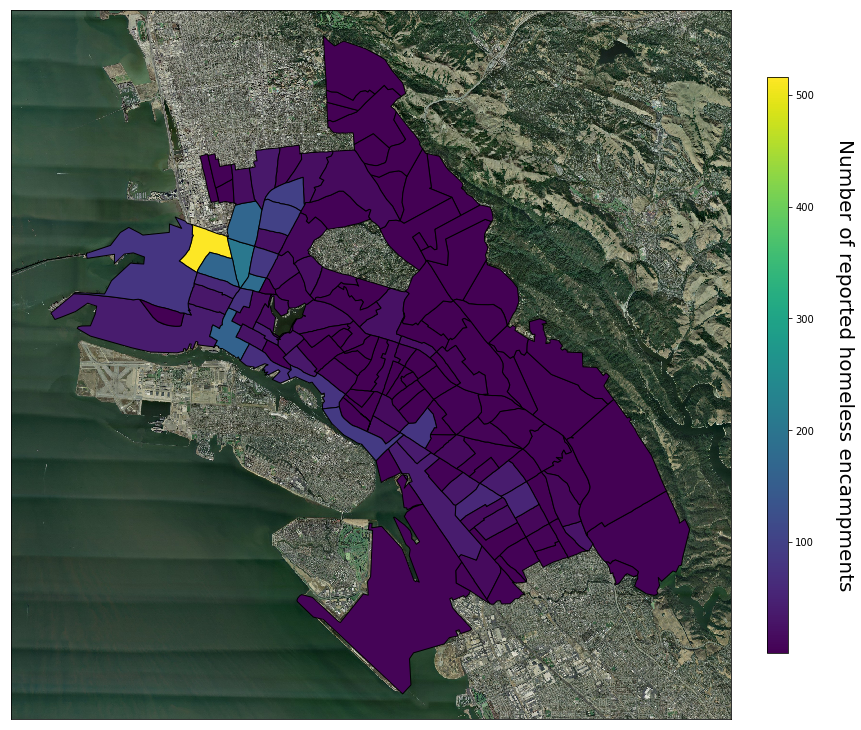

In [44]:
neighborhood_heat_map(data=neighborhoods,
                      col='N_HOMELESS',
                      coords=coords,
                      label='Number of reported homeless encampments',
                      ax=None,
                      xpixels=2000);

## 4. Summary
In this notebook, we:
1. Read in the service request log
1. Determined geospatially where many of these requests occurred
1. Looked at naive distributions of the intervals between events opening and closing
1. Looked at some particular service requests of interest

### What data we dropped
It's worth noting what transformations were done on the data so we know the scope of it moving forward. Here is what was done:
1. Any request that had a GPS coordinate that didn't fall within one of the Oakland neighborhoods.


### Moving forward
The data studied in this notebook gives us additional questions to ask, and where we can focus our efforts. Some ideas to explore more include:
- Can we relate any specific categories (e.g., grafitti reports, homeless encampments) to the more gentrified areas? From my understanding of Oakland, the hot spots of these types of reports were mostly concentrated around the more gentrified areas of Oakland (namely, West Oakland).
- For one of these categories of interest, what can we say about the distribution of time intervals, or the preferred means of reporting (e.g., online or on the phone).

In [45]:
service_requests.to_hdf(RESULTSDIR + '02-service_requests.h5', 'service_requests')

/Users/kjbilton/Installs/miniconda2/envs/oakland/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['SOURCE', 'DESCRIPTION', 'REQCATEGORY', 'STATUS', 'coordinates', 'neighborhood']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
